# 0 Agricultural carbon绘制图

## 0.1 Load data

In [1]:
import sys
import os
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

DATA_PATH = Path(project_root, 'data')

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from function import *  

PATHS.update({'us_pv_embedding': DATA_PATH / 'training_embedding.csv'})

def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped

# 读取数据
df_agricultural_carbon = pd.read_csv('../data/4.1 Restoration_strategy_data.csv')
us_nation = gpd.read_file(r'..\data\US_data\cb_2018_us_nation_5m.shp')
df_embedding = load_embedding(PATHS['us_pv_embedding'])

usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)

df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

df_agricultural_carbon = df_agricultural_carbon[
    (df_agricultural_carbon['lon'] >= usa_bounds_main['lon_min']) &
    (df_agricultural_carbon['lon'] <= usa_bounds_main['lon_max']) &
    (df_agricultural_carbon['lat'] >= usa_bounds_main['lat_min']) &
    (df_agricultural_carbon['lat'] <= usa_bounds_main['lat_max'])
]
df_embedding = clip_data_with_us_states(df_embedding, us_nation)
df_agricultural_carbon=clip_data_with_us_states(df_agricultural_carbon,us_nation)

df_agricultural_carbon_fill   = fill_nonpositive_with_nearest(df_agricultural_carbon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_agricultural_carbon_fill = filter_duplicates(df_agricultural_carbon_fill, df_embedding_fill)

PERENNIAL_KEYWORDS = [
    'Alfalfa','Banana','Citrus','Cocoa','Coffee','Coconut',
    'Oil palm','Rubber','Sugarcane','Tea'
]
perennial_columns = [col for col in df_agricultural_carbon_fill.columns if any(keyword in col for keyword in PERENNIAL_KEYWORDS)]








gogogo
✅ TensorFlow available
✅ scikeras available
✅ SHAP available
列 GDPpc 没有需要填充的非正值或NaN值
列 gdmp 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值


## 0.2 Perennial crops suitability level 

In [4]:
# 完善后的代码

# 构建多年生作物适宜性 DataFrame
perennial_df = df_agricultural_carbon_fill[perennial_columns + ['lat', 'lon', 'area_m2']].copy()

# 判断不同等级的掩码
# 仅出现1（即有作物列至少为1，且所有列都不为2）
mask_only_1 = ((perennial_df[perennial_columns] == 1).any(axis=1)) & (~(perennial_df[perennial_columns] == 2).any(axis=1))

# 仅出现2（即有作物列至少为2，且所有列都不为1）
mask_only_2 = ((perennial_df[perennial_columns] == 2).any(axis=1)) & (~(perennial_df[perennial_columns] == 1).any(axis=1))

# 既出现1又出现2（即有作物列为1，且同一行有作物列为2）——将这部分计为优质土地，与mask_only_1合并统计
mask_1_and_2 = ((perennial_df[perennial_columns] == 1).any(axis=1)) & ((perennial_df[perennial_columns] == 2).any(axis=1))

# 其余情况：所有值都不是1和2，且至少有一个作物列>=3
mask_rest_3plus = (~(perennial_df[perennial_columns] == 1).any(axis=1)) & \
                  (~(perennial_df[perennial_columns] == 2).any(axis=1)) & \
                  ((perennial_df[perennial_columns] >= 3).any(axis=1))


# 计算每类状态的面积，分别列出各自面积，不合并
# 1. ==1 only
# 2. ==2 only
# 3. 既有1又有2（1&2 同时出现）
# 4. 其它≥3

area_vals = [
    perennial_df.loc[mask_only_1, 'area_m2'].sum(),      # 仅为1
    perennial_df.loc[mask_only_2, 'area_m2'].sum(),      # 仅为2
    perennial_df.loc[mask_1_and_2, 'area_m2'].sum(),     # 同时有1和2
    perennial_df.loc[mask_rest_3plus, 'area_m2'].sum()   # 其它≥3
]

total_area = sum(area_vals)

# 统一为ha和百分比
area_kha = [val / 1e7 for val in area_vals]  # kha
area_percent = [val / total_area * 100 if total_area > 0 else 0 for val in area_vals]

# 构建结果DataFrame
area_sum_df = pd.DataFrame({
    'status': ['==1 only', '==2 only', '==1&2 both', '>=3 or higher'],
    'area_kha': area_kha,
    'percent_of_total': area_percent
})

print(area_sum_df)
area_sum_df

          status     area_kha  percent_of_total
0       ==1 only   124.365180          2.644179
1       ==2 only   881.259281         18.736814
2     ==1&2 both    72.101147          1.532972
3  >=3 or higher  3625.631574         77.086035


,status,area_kha,percent_of_total
0,==1 only,124.365180,2.644179
1,==2 only,881.259281,18.736814
2,==1&2 both,72.101147,1.532972
3,>=3 or higher,3625.631574,77.086035


In [5]:
perennial_df

,Sugarcane_1981-2010_Historical_With CO2 Fertilization,Coconut_1981-2010_Historical_With CO2 Fertilization,Rubber_1981-2010_Historical_With CO2 Fertilization,Oil palm_1981-2010_Historical_With CO2 Fertilization,Citrus_1981-2010_Historical_With CO2 Fertilization,Tea_1981-2010_Historical_With CO2 Fertilization,Banana_1981-2010_Historical_With CO2 Fertilization,Cocoa_1981-2010_Historical_With CO2 Fertilization,Alfalfa_1981-2010_Historical_With CO2 Fertilization,Coffee_1981-2010_Historical_With CO2 Fertilization,lat,lon,area_m2
0,5.0,5.0,4.0,5.0,6.0,5.0,6.0,5.0,6.0,5.0,25.295834,-80.287500,776295.361002
1,6.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,25.437500,-80.537500,775385.854124
2,6.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,25.437500,-80.495834,775385.854124
3,6.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,25.445833,-80.454170,775332.207938
4,6.0,5.0,4.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,25.445833,-80.404170,775332.207938
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70332,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,5.0,8.0,48.995834,-99.995834,563356.382622
70333,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,5.0,8.0,48.995834,-99.987500,563356.382622
70334,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,5.0,8.0,48.995834,-99.895836,563356.382622
70335,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,5.0,8.0,48.995834,-99.887500,563356.382622


In [6]:
# 检查是否会存在重复值

perennial_extract_dfs = []

for keyword in PERENNIAL_KEYWORDS:
    # 找出所有与该作物关键字匹配的列
    crop_columns = [col for col in perennial_columns if keyword in col]
    if not crop_columns:
        continue  # 如果该作物没有匹配，跳过
    # 选出任一相关列值为1或2的位置
    mask = (df_agricultural_carbon_fill[crop_columns] == 1) | (df_agricultural_carbon_fill[crop_columns] == 2)
    suitable_mask = mask.any(axis=1)
    # 构建该作物的中间结果
    crop_df = df_agricultural_carbon_fill.loc[suitable_mask, crop_columns + ['lat', 'lon', 'area_m2']].copy()
    crop_df['crop'] = keyword
    perennial_extract_dfs.append(crop_df)

# 合并所有作物的结果
perennial_extract_df = pd.concat(perennial_extract_dfs, ignore_index=True) if perennial_extract_dfs else pd.DataFrame()

# 检查是否存在重复（同一lat/lon组合是否多次出现）
duplicates_latlon = perennial_extract_df.duplicated(subset=['lat', 'lon'], keep=False)
num_duplicates_latlon = duplicates_latlon.sum()

print(f"相同 lat/lon 组合的重复行数: {num_duplicates_latlon}")
if num_duplicates_latlon > 0:
    print("存在相同 lat/lon 组合的重复值。可以用 drop_duplicates(subset=['lat', 'lon']) 去重。")

# 如需去重，使用如下代码（可选）:
perennial_extract_df = perennial_extract_df.drop_duplicates(subset=['lat', 'lon'])

perennial_extract_df

相同 lat/lon 组合的重复行数: 5145
存在相同 lat/lon 组合的重复值。可以用 drop_duplicates(subset=['lat', 'lon']) 去重。


,Alfalfa_1981-2010_Historical_With CO2 Fertilization,lat,lon,area_m2,crop,Banana_1981-2010_Historical_With CO2 Fertilization,Citrus_1981-2010_Historical_With CO2 Fertilization,Cocoa_1981-2010_Historical_With CO2 Fertilization,Coffee_1981-2010_Historical_With CO2 Fertilization,Coconut_1981-2010_Historical_With CO2 Fertilization,Oil palm_1981-2010_Historical_With CO2 Fertilization,Rubber_1981-2010_Historical_With CO2 Fertilization,Sugarcane_1981-2010_Historical_With CO2 Fertilization,Tea_1981-2010_Historical_With CO2 Fertilization
0,2.0,26.004168,-97.520836,771700.453607,Alfalfa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,26.029167,-97.554170,771536.128139,Alfalfa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,26.037500,-97.545830,771481.320343,Alfalfa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,26.070833,-97.520836,771261.919395,Alfalfa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,26.070833,-97.504166,771261.919395,Alfalfa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18983,NaN,35.945835,-83.829170,695119.735577,Tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
18984,NaN,36.320835,-80.554170,691805.997452,Tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
18986,NaN,37.179165,-75.954170,684109.937590,Tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
18987,NaN,37.270832,-75.970830,683278.917831,Tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


## 0.3 Maps of crop distribution 

### helper function

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box, LineString
from shapely.ops import unary_union
try:
    from shapely import make_valid
except Exception:
    make_valid = None
import rioxarray
from shapely.geometry import mapping

def _render_terrain(ax, dem_data, usa_bounds_main, transformer):
    """渲染地形"""
    qm = None
    dem_lon = dem_data.x.values
    dem_lat = dem_data.y.values
    lon_mask = (dem_lon >= usa_bounds_main['lon_min']) & (dem_lon <= usa_bounds_main['lon_max'])
    lat_mask = (dem_lat >= usa_bounds_main['lat_min']) & (dem_lat <= usa_bounds_main['lat_max'])
    
    if lon_mask.any() and lat_mask.any():
        lon_idx = np.where(lon_mask)[0]
        lat_idx = np.where(lat_mask)[0]
        
        # 抽稀栅格
        step_x = max(1, len(lon_idx)//1800)
        step_y = max(1, len(lat_idx)//900)
        lon_sub = lon_idx[::step_x]
        lat_sub = lat_idx[::step_y]
        elev = dem_data.squeeze().values[np.ix_(lat_sub, lon_sub)]

        mask = ~np.isnan(elev)
        if mask.any():
            lo = np.nanpercentile(elev, 35)
            elev[elev < lo] = np.nan

            # 地形配色
            terrain_colors = ListedColormap(["#ffffff", "#eef3ef", "#dfe8e0",
                                           "#d2ddcf", "#c7d1c1", "#b7c2af"])
            terrain_colors.set_bad((0, 0, 0, 0))
            qs = np.nanpercentile(elev, [35, 50, 65, 78, 88, 98])
            norm = BoundaryNorm(qs, terrain_colors.N)

            lon_grid, lat_grid = np.meshgrid(dem_lon[lon_sub], dem_lat[lat_sub])
            gx, gy = transformer.transform(lon_grid, lat_grid)            
            qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,
                              shading='auto', alpha=0.55, antialiased=False, zorder=1)
            qm.set_clip_on(True)
    
    return qm


def _draw_glow_outline_outside(ax, gdf_albers, line_color="#444444", line_width=0.8,
                              widths_km=(0, 30, 50), alphas=(0.95, 0.5, 0.3), 
                              colors=("#08336e", "#105ca4", "#3888c0")):
    """绘制国界线光晕效果"""
    g = gdf_albers.copy()
    geom = unary_union(g.geometry)
    
    if make_valid is not None:
        geom = make_valid(geom)
    else:
        geom = geom.buffer(0)

    radii_m = [k*1000.0 for k in widths_km]
    ordered = list(zip(radii_m, alphas, colors))
    ordered.sort(key=lambda x: x[0])

    last_inner = geom.buffer(0, join_style=2, cap_style=2)
    glow_meshes = []
    
    for i, (r, alpha, color) in enumerate(ordered):
        outer = geom.buffer(r, join_style=2, cap_style=2)
        ring = outer.difference(last_inner)
        if not ring.is_empty:
            glow_series = gpd.GeoSeries([ring], crs=g.crs)
            glow_mesh = glow_series.plot(ax=ax, color=color, alpha=alpha, edgecolor="none",
                                       zorder=8.2 + i*0.01)
            glow_meshes.append(glow_mesh)
        last_inner = outer

    g.boundary.plot(ax=ax, color=line_color, linewidth=line_width, zorder=9.6)
    return glow_meshes


def _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格，标签显示在上方和左侧（曲线网格）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 绘制曲线网格线
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 在顶部显示标签
        p = _choose_point_on_edge(line.intersection(top))
        if p is not None:
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                ax.text(p.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 绘制曲线网格线
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧显示标签
        p = _choose_point_on_edge(line.intersection(left))
        if p is not None:
            yticks.append(p.y)
            ax.text(xmin - (xmax - xmin) * 0.02, p.y, f"{int(round(lat))}°N",
                   ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                           edgecolor='none'))



### Plot function

In [34]:

def plot_perennial_crops(
    perennial_df,
    perennial_extract_df,
    us_states_gdf,
    us_nation_gdf,
    dem_data=None,
    title="Perennial Crops Suitability",
    background_alpha=0.3,
    highlight_alpha=0.9,
    highlight_color='#ff4444'
):
    """
    绘制多年生作物适宜性分布图
    
    Parameters:
    -----------
    perennial_df : DataFrame
        所有多年生作物数据（背景，较淡）
    perennial_extract_df : DataFrame
        适宜性等级为1或2的像元（前景，鲜艳）
    us_states_gdf : GeoDataFrame
        美国州界数据
    us_nation_gdf : GeoDataFrame
        美国国界数据
    dem_data : xarray.Dataset, optional
        DEM地形数据
    title : str, optional
        图表标题
    background_alpha : float, default 0.3
        背景数据点的透明度
    highlight_alpha : float, default 0.9
        高亮数据点的透明度
    highlight_color : str, default '#ff4444'
        高亮数据点的颜色（鲜艳的红色）
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })

    # 创建图形和坐标轴
    fig, ax = plt.subplots(1, 1, figsize=(150/25.4, 90/25.4))  
    ax.set_autoscale_on(False)
    fig.patch.set_facecolor('white')      

    # ==================== 地理边界设置 ====================
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    
    # 处理州界数据
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    
    # 处理国界线
    us_nation_bound = us_nation_gdf.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')

    # ==================== 坐标变换设置 ====================
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    # ==================== 地图范围计算 ====================
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds

    # 减小边界，让图幅更大
    margin_x = (xmax - xmin) * 0.02  
    margin_y = (ymax - ymin) * 0.02
    
    xmin = xmin - margin_x
    xmax = xmax + margin_x
    ymin = ymin - margin_y
    ymax = ymax + margin_y

    # 设置坐标轴位置和范围
    ax.set_position([0.07, 0.17, 0.9, 0.9])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ==================== 地形渲染 ====================
    qm = None
    if dem_data is not None:
        qm = _render_terrain(ax, dem_data, usa_bounds_main, transformer)

    # ==================== 地图元素绘制 ====================
    # 绘制国界线光晕效果
    _draw_glow_outline_outside(ax, us_nation_albers)
    
    # 绘制州界
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4, alpha=0.4, zorder=9)

    # ==================== 取消坐标轴和网格 ====================
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    lon_ticks = np.arange(-115, -65, 10)
    lat_ticks = [30, 35, 40, 45]
    
    # 绘制曲线网格线
    _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)

    # ==================== 数据可视化 ====================
    # 1. 绘制背景数据（perennial_df）- 较淡的颜色
    if len(perennial_df) > 0:
        x_bg, y_bg = transformer.transform(perennial_df['lon'].values, 
                                           perennial_df['lat'].values)
        # 使用更深的黄色作为背景
        ax.scatter(x_bg, y_bg, c='#ffe082', s=0.2, alpha=background_alpha, 
                  edgecolors='none', zorder=3, label='All perennial crops')

    # 2. 绘制高亮数据（perennial_extract_df）- 鲜艳的颜色
    if len(perennial_extract_df) > 0:
        x_hl, y_hl = transformer.transform(perennial_extract_df['lon'].values, 
                                          perennial_extract_df['lat'].values)
        # 使用鲜艳的颜色标记适宜性等级为1或2的像元
        ax.scatter(x_hl, y_hl, c=highlight_color, s=0.5, alpha=highlight_alpha, 
                  edgecolors='none', zorder=6, label='Suitability level 1-2')

    # ==================== 添加图例（左下角）====================
    # 创建自定义图例元素
    from matplotlib.patches import Rectangle
    
    # 直接按间距绘制两个图例项（无图例框）
    # 计算左下角参考位置
    legend_x = xmin + (xmax - xmin) * 0.025  # 距离左边界2.5%
    legend_y = ymin + (ymax - ymin) * 0.03   # 距离下边界3%
    legend_padding = (ymax - ymin) * 0.04    # 项间距

    marker_size = 8

    # 1. Perennial crops (多年生作物) - 红色
    ax.scatter(legend_x, legend_y + legend_padding, 
               c=highlight_color, s=marker_size, alpha=highlight_alpha, 
               edgecolors='none', zorder=51)
    ax.text(legend_x + legend_padding * 1.5, legend_y + legend_padding, 
            'Perennial crops', fontsize=5, va='center', ha='left', 
            zorder=52, color='#333333', fontweight='normal')

    # 2. Annual crops (一年生作物) - 黄色
    annual_color = '#ffd700'
    ax.scatter(legend_x, legend_y, 
               c=annual_color, s=marker_size, alpha=0.8, 
               edgecolors='none', zorder=51)
    ax.text(legend_x + legend_padding * 1.5, legend_y, 
            'Annual crops', fontsize=5, va='center', ha='left', 
            zorder=52, color='#333333', fontweight='normal')

    # ==================== 最终处理 ====================
    fig.canvas.draw()          
    if qm is not None:
        qm.set_clip_path(ax.patch)
        qm.set_rasterized(True)

    return fig, ax


In [ ]:
# 加载DEM数据和州界数据（如果需要地形渲染）
try:
    import rioxarray
    dem = rioxarray.open_rasterio(DATA_PATH.parent / 'figure' / 'draw_shp' / 'DEM.nc', masked=True)
    if dem.rio.crs is None:
        dem = dem.rio.write_crs("EPSG:4326")
    # 裁剪DEM到美国范围
    dem_us = dem.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)
    print("DEM数据加载成功")
except Exception as e:
    print(f"DEM数据加载失败: {e}")
    dem_us = None

C:\Users\zpy10\AppData\Local\Temp\ipykernel_58052\2863847703.py:49: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


图片已保存到: Supplymentary_figure\perennial_crops_suitability.png


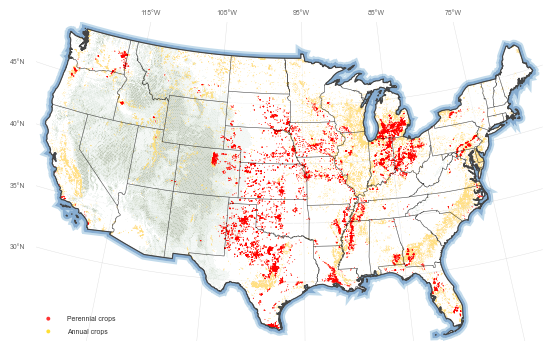

In [35]:


# 加载州界数据
us_states = gpd.read_file(DATA_PATH / 'cb_2018_us_state_500k.shp')

# 使用绘图函数
fig, ax = plot_perennial_crops(
    perennial_df=perennial_df,
    perennial_extract_df=perennial_extract_df,
    us_states_gdf=us_states,
    us_nation_gdf=us_nation,
    dem_data=dem_us,  
    title="Perennial Crops Suitability Distribution",
    background_alpha=0.8,  # 背景透明度
    highlight_alpha=0.8,   # 高亮透明度
    highlight_color='#ff0000'  # 鲜艳的红色
)

# 添加标题（如果需要）
# fig.suptitle("Perennial Crops Suitability", fontsize=8, y=0.95)

# 保存图片到 Supplymentary/Supplymentary_figure
output_dir = Path('Supplymentary_figure')
output_dir.mkdir(parents=True, exist_ok=True)

filename_png = output_dir / 'perennial_crops_suitability.png'
filename_pdf = output_dir / 'perennial_crops_suitability.pdf'

fig.savefig(filename_png, dpi=300, facecolor='white', bbox_inches='tight')
fig.savefig(filename_pdf, dpi=300, facecolor='none', bbox_inches='tight')

print(f"图片已保存到: {filename_png}")
plt.show()
plt.close(fig)


# 1 Carbon Storage Maps for Three LNCS Strategies

## 1.1 Load data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from function import *  


project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

DATA_PATH = Path(project_root, 'data')
PATHS.update({'us_pv_embedding': DATA_PATH / 'training_embedding.csv'})

df_weight = pd.read_csv('../data/US_data/df_weight.csv')
us_nation = gpd.read_file(r'..\data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'..\data\cb_2018_us_state_500k.shp')

# 加载DEM数据和州界数据（如果需要地形渲染）
try:
    import rioxarray
    dem = rioxarray.open_rasterio(DATA_PATH.parent / 'figure' / 'draw_shp' / 'DEM.nc', masked=True)
    if dem.rio.crs is None:
        dem = dem.rio.write_crs("EPSG:4326")
    # 裁剪DEM到美国范围
    dem_us = dem.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)
    print("DEM数据加载成功")
except Exception as e:
    print(f"DEM数据加载失败: {e}")
    dem_us = None


DEM数据加载成功


## 1.2 Plot (Need helper at 0.3)

In [47]:


def plot_carbon_storage_single(
    df_weight,
    col_name,
    title,
    us_states_gdf,
    us_nation_gdf,
    dem_data=None,
    figsize=(90/25.4, 60/25.4),
    vmin=None,
    vmax=None,
    cmap=None
):
    """
    绘制单个策略的碳储量分布图（采用plot_ccd_optimized_global_style_with_dem的颜色映射方式）
    
    Parameters:
    -----------
    df_weight : DataFrame
        包含lat, lon和碳储量列的数据框（已裁剪）
    col_name : str
        要绘制的列名
    title : str
        图表标题
    us_states_gdf : GeoDataFrame
        美国州界数据
    us_nation_gdf : GeoDataFrame
        美国国界数据
    dem_data : xarray.Dataset, optional
        DEM地形数据
    figsize : tuple, default (90/25.4, 60/25.4)
        图形尺寸（mm转换为英寸）
    vmin, vmax : float, optional
        颜色范围的最小值和最大值
    cmap : matplotlib colormap, optional
        颜色映射，如果为None则根据col_name自动选择
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm, ListedColormap
    from pyproj import Transformer
    from shapely.geometry import box
    
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })
    
    if cmap is None:
        if 'agro' in col_name.lower() or 'agricultural' in col_name.lower():
            cmap = plt.cm.YlOrRd
        elif 'forest' in col_name.lower():
            cmap = plt.cm.Greens
        elif 'veg' in col_name.lower() or 'vegetation' in col_name.lower():
            cmap = plt.cm.Blues
        else:
            # 更换为新配色方案：使用viridis
            cmap = plt.cm.viridis
    
    # 创建单个图形
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.patch.set_facecolor('white')
    ax.set_autoscale_on(False)
    ax.set_facecolor('#e6f3ff')
    
    # 地理边界设置
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    
    # 处理州界和国界数据
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    us_nation_bound = us_nation_gdf.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')
    
    # 坐标变换
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)
    
    # 地图范围
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds
    margin_x = (xmax - xmin) * 0.02
    margin_y = (ymax - ymin) * 0.02
    xmin -= margin_x
    xmax += margin_x
    ymin -= margin_y
    ymax += margin_y
    
    # 设置坐标轴位置和范围
    ax.set_position([0.07, 0.17, 0.9, 0.78])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    

    # 先获取数据用于计算bins
    bins = None
    if col_name in df_weight.columns:
        valid_values = df_weight[col_name].dropna()
        pos_all = valid_values[valid_values > 0]
        
        if len(pos_all) > 0:
            # 计算11个分位数阈值（0,10,20,30,40,50,60,70,80,90,100）
            bins = np.percentile(pos_all, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
            
            # 如果vmin/vmax未指定，使用数据的1%和99%分位数
            if vmin is None:
                vmin = np.nanpercentile(valid_values, 1)
            if vmax is None:
                vmax = np.nanpercentile(valid_values, 99)
        else:
            bins = np.linspace(0, 1, 11)
            if vmin is None:
                vmin = 0
            if vmax is None:
                vmax = 1
    else:
        bins = np.linspace(0, 1, 11)
        if vmin is None:
            vmin = 0
        if vmax is None:
            vmax = 1
    
    # 地形渲染
    qm = None
    if dem_data is not None:
        qm = _render_terrain(ax, dem_data, usa_bounds_main, transformer)
    
    # 绘制国界线光晕
    _draw_glow_outline_outside(ax, us_nation_albers)
    
    # 绘制州界
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', 
                         linewidth=0.4, alpha=0.4, zorder=9)
    
    # 取消坐标轴
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # 绘制网格线
    lon_ticks = np.arange(-115, -65, 10)
    lat_ticks = [30, 35, 40, 45]
    _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, 
                              usa_bounds_main, proj_fwd, proj_inv)
    
    # 绘制数据点（参照plot_ccd_optimized_global_style_with_dem，使用BoundaryNorm）
    scatter = None
    if col_name in df_weight.columns:
        data_subset = df_weight[['lat', 'lon', col_name]].dropna()
        if len(data_subset) > 0:
            x_proj, y_proj = transformer.transform(
                data_subset['lon'].values,
                data_subset['lat'].values
            )
            values = data_subset[col_name].values

            cmap_colors = [cmap(i/10.0) for i in range(11)]
            carbon_cmap = LinearSegmentedColormap.from_list("carbon_cmap", cmap_colors, N=11)
            
            # 使用之前计算的bins，如果bins为None则重新计算
            if bins is None:
                pos_all = values[values > 0]
                if len(pos_all) > 0:
                    bins = np.percentile(pos_all, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
                else:
                    bins = np.linspace(vmin if vmin is not None else 0, vmax if vmax is not None else 1, 11)
            
            # 使用BoundaryNorm
            carbon_norm = BoundaryNorm(bins, ncolors=carbon_cmap.N)
            
            # 对于0值或负值，使用灰色
            values_plot = values.copy()
            colors_plot = []
            for v in values:
                if v <= 0:
                    colors_plot.append('lightgray')
                else:
                    # 使用norm来映射颜色
                    colors_plot.append(carbon_cmap(carbon_norm(v)))
            
            # 使用scatter绘制
            scatter = ax.scatter(x_proj, y_proj, c=colors_plot, s=0.3, alpha=0.8,
                                edgecolors='none', zorder=5)

    
    if scatter is not None and bins is not None:
        # 确保carbon_cmap和carbon_norm已定义（如果未定义则创建）
        if 'carbon_cmap' not in locals() or carbon_cmap is None:
            # 从cmap中提取11个颜色
            cmap_colors = [cmap(i/10.0) for i in range(11)]
            carbon_cmap = LinearSegmentedColormap.from_list("carbon_cmap", cmap_colors, N=11)
        
        if 'carbon_norm' not in locals() or carbon_norm is None:
            # 使用BoundaryNorm
            carbon_norm = BoundaryNorm(bins, ncolors=carbon_cmap.N)
        
        # colorbar位置和大小
        pos = ax.get_position()
        c_w = 0.45 * pos.width
        c_h = 0.035
        c_left = pos.x0 + 0.25 * pos.width
        c_bottom = 0.09
        cax = fig.add_axes([c_left, c_bottom, c_w, c_h])
        cax.set_in_layout(False)
        
        # 创建colorbar
        from matplotlib.cm import ScalarMappable
        sm = ScalarMappable(cmap=carbon_cmap, norm=carbon_norm)
        sm.set_array([])
        cb = fig.colorbar(sm, cax=cax, orientation='horizontal')
        cb.set_ticks(bins[1::2])
        cb.set_ticklabels([f"{v:.2f}" for v in bins[1::2]])
        
        # tick样式（参照plot_ccd_optimized_global_style_with_dem）
        cax.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=1, labelsize=5)
        cax.tick_params(axis='x', which='minor', length=1.5, width=0.4, label1On=False)
        cb.outline.set_linewidth(0.7)
        
        # 顶部Top%标签（参照plot_ccd_optimized_global_style_with_dem）
        top_labels = [f"Top{p}" for p in range(10, 101, 20)][::-1]  # ['Top90', 'Top70', 'Top50', 'Top30', 'Top10']
        for loc, lab in zip(cb.get_ticks(), top_labels):
            x_disp = cax.transData.transform((loc, 0))[0]
            x_frac = cax.transAxes.inverted().transform((x_disp, 0))[0]
            cax.text(x_frac, 1.15, lab, transform=cax.transAxes,
                     ha='center', va='bottom', fontsize=5)
        
        unit_display = "Carbon Storage (MgC/ha)"
        cax.text(0.5, -1.4, unit_display, ha='center', va='top', fontsize=5, 
                fontweight='bold', transform=cax.transAxes)
    
    # 最终处理
    if qm is not None:
        qm.set_clip_path(ax.patch)
        qm.set_rasterized(True)
    
    fig.canvas.draw()
    
    return fig, ax


In [48]:

all_values = []
for col in ['final_agro', 'final_forest', 'final_veg']:
    if col in df_weight.columns:
        valid_values = df_weight[col].dropna()
        if len(valid_values) > 0:
            all_values.extend(valid_values.values)

if len(all_values) > 0:
    import numpy as np
    vmin_common = np.nanpercentile(all_values, 1)
    vmax_common = np.nanpercentile(all_values, 99)
else:
    vmin_common, vmax_common = None, None

# 三个策略的配置
strategies = [
    ('final_agro', 'Agricultural'),
    ('final_forest', 'Forest'),
    ('final_veg', 'Vegetation')
]

# 绘制每个策略的单独图
output_dir = Path('Supplymentary_figure')
output_dir.mkdir(parents=True, exist_ok=True)

figs = []
for col, title in strategies:
    fig, ax = plot_carbon_storage_single(
        df_weight=df_weight,
        col_name=col,
        title=title,
        us_states_gdf=us_states,
        us_nation_gdf=us_nation,
        dem_data=dem_us,
        figsize=(90/25.4, 60/25.4)
    )
    
    # 保存图片（不使用tight）
    filename_png = output_dir / f'carbon_storage_{col}.png'
    filename_pdf = output_dir / f'carbon_storage_{col}.pdf'
    
    fig.savefig(filename_png, dpi=300, facecolor='white')
    fig.savefig(filename_pdf, dpi=300, facecolor='none')
    
    print(f"图片已保存到: {filename_png}")
    figs.append((fig, col))
    plt.close(fig)

# 计算加权组合：final_agro*weighted_density_Agricultural + final_forest*weighted_density_Forest + final_veg*weighted_density_Vegetation
if all(col in df_weight.columns for col in ['final_agro', 'final_forest', 'final_veg', 
                                             'weighted_density_Agricultural', 
                                             'weighted_density_Forest', 
                                             'weighted_density_Vegetation']):
    df_weight['weighted_combined'] = (
        df_weight['final_agro'] * df_weight['weighted_density_Agricultural'] +
        df_weight['final_forest'] * df_weight['weighted_density_Forest'] +
        df_weight['final_veg'] * df_weight['weighted_density_Vegetation']
    )
    
    # 绘制加权组合图
    fig, ax = plot_carbon_storage_single(
        df_weight=df_weight,
        col_name='weighted_combined',
        title='Weighted Combined',
        us_states_gdf=us_states,
        us_nation_gdf=us_nation,
        dem_data=dem_us,
        figsize=(90/25.4, 60/25.4)
    )
    
    filename_png = output_dir / 'carbon_storage_weighted_combined.png'
    filename_pdf = output_dir / 'carbon_storage_weighted_combined.pdf'
    
    fig.savefig(filename_png, dpi=300, facecolor='white')
    fig.savefig(filename_pdf, dpi=300, facecolor='none')
    
    print(f"加权组合图已保存到: {filename_png}")
    plt.close(fig)
else:
    print("警告：缺少必要的列来计算加权组合图")
    missing_cols = []
    for col in ['final_agro', 'final_forest', 'final_veg', 
                'weighted_density_Agricultural', 'weighted_density_Forest', 'weighted_density_Vegetation']:
        if col not in df_weight.columns:
            missing_cols.append(col)
    print(f"缺少的列: {missing_cols}")


C:\Users\zpy10\AppData\Local\Temp\ipykernel_40524\2863847703.py:49: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


图片已保存到: Supplymentary_figure\carbon_storage_final_agro.png


C:\Users\zpy10\AppData\Local\Temp\ipykernel_40524\2863847703.py:49: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


图片已保存到: Supplymentary_figure\carbon_storage_final_forest.png


C:\Users\zpy10\AppData\Local\Temp\ipykernel_40524\2863847703.py:49: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


图片已保存到: Supplymentary_figure\carbon_storage_final_veg.png


C:\Users\zpy10\AppData\Local\Temp\ipykernel_40524\2863847703.py:49: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


加权组合图已保存到: Supplymentary_figure\carbon_storage_weighted_combined.png
